# Importação das bibliotecas

In [3]:
!pip install xgboost
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LassoCV
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, RepeatedKFold, cross_val_predict, cross_validate, ShuffleSplit
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from IPython.display import Image, display
from datetime import datetime
import catboost as cb
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBRegressor



# Leitura dos dados

O dataset contém dados de transações imobiliárias de King County, região aonde está a cidade de Seattle, USA.

In [5]:
sales = pd.read_csv("kc_house_data.csv")

# Pré-processamento

## Conversão feature date

A feature date no conjunto original é do tipo "object".

Inicialmente iremos transformá-la para um "datetime" para realizar alguns outros tratamentos posteriores.

In [6]:
# Função para converter string para datetime
def converter_para_datetime(date):
    return datetime.strptime(date, "%Y%m%dT%H%M%S")

# Aplicar a função à coluna do DataFrame
sales['data_formatada'] = sales['date'].apply(converter_para_datetime)
sales = sales.drop(columns=['date'])

## Tratamento de outliers

### Feature bedrooms

Na EDA foi identificado que existe uma casa com quantidade de quartos igual a 33.

Essa casa possui uma área interna pequena para essa quantidade de quartos e o seu preço também não é tão alto assim.

Assim, esse valor de 33 será substituído pela mediana dos outros registros, que é de 3.

In [7]:
filtro_33_quartos = sales['bedrooms'] > 32
sales[filtro_33_quartos]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,data_formatada
15870,2402100895,640000.0,33,1.75,1620,6000,1.0,0,0,5,...,1040,580,1947,0,98103,47.6878,-122.331,1330,4700,2014-06-25


In [8]:
mediana_quartos = sales['bedrooms'].median()
print('Mediana encontrada:', mediana_quartos)

Mediana encontrada: 3.0


In [9]:
sales.loc[sales['bedrooms'] == 33, 'bedrooms'] = mediana_quartos

## Múltiplas vendas para a mesma casa

Na EDA foi observado que existiam registros com o "id" repetido, indicando que uma mesma casa foi vendida mais de uma vez no período registrado no conjunto de dados.

Para não ocasionar uma redundância dos dados essas múltiplas vendas foram tratadas mantendo apenas o registro com data de venda mais recente.

Note que a quantidade de registros original é de 21.613. E após o tratamento passa a ser de 21.436. Ou seja, foram reduzidos 177 registros de vendas múltiplas.


In [10]:
#  índice da linha com a data mais recente para cada 'id'
idx_ultima_data = sales.groupby('id')['data_formatada'].idxmax()

sales_sem_duplicatas = sales.loc[idx_ultima_data]

# Resetar o índice, se necessário
sales_sem_duplicatas = sales_sem_duplicatas.reset_index(drop=True)

In [11]:
print(sales.shape)
print(sales_sem_duplicatas.shape)

(21613, 21)
(21436, 21)


Com esse tratamento, não precisamos mais da coluna "id".

In [12]:
sales_sem_duplicatas.drop(['id'], axis=1, inplace=True)

## Feature date

Anteriormente a feature "date" foi modificada para um "datetime", utilizando a nova nomenclatura "data_formatada". Sendo usada no tratamento das vendas múltiplas.

Nessa etapa iremos remover essa coluna, tranformando-a em 3 novas colunas:


*   ano: ano da venda.
*   mes: mês da venda. Ficando 11 colunas.  Isso é suficiente para representar completamente a informação, pois se todas as outras dummy variables são 0, significa que a categoria omitida está presente.
*   dia_semana: dia da semana da venda. Indo de 0 a 6. 0=Segunda-feira e 6=Domingo.

In [13]:
sales_sem_duplicatas.shape

(21436, 20)

In [14]:
sales_sem_duplicatas['ano'] = sales_sem_duplicatas['data_formatada'].dt.year
sales_sem_duplicatas['mes'] = sales_sem_duplicatas['data_formatada'].dt.month
sales_sem_duplicatas['dia_semana'] = sales_sem_duplicatas['data_formatada'].dt.dayofweek
sales_sem_duplicatas.drop(['data_formatada'],axis=1,inplace=True)

In [15]:
sales_sem_duplicatas.shape

(21436, 22)

## Feature yr_renovated

Na EDA foi possível perceber que muitas casas possuíam a feature "yr_renovated" zerada, indicando que essas casas não passaram por uma renovação.

Dessa forma foi criada a coluna "renovada" para indicar se a casa passou por uma renovação ou não.


In [16]:
sales_sem_duplicatas['renovada'] = (sales_sem_duplicatas['yr_renovated'] > 0)
sales_sem_duplicatas['renovada']= sales_sem_duplicatas['renovada'].astype(int)
sales_sem_duplicatas.shape

(21436, 23)

## Feature sqft_basement

A feature "sqft_basement" possui registros zerados, indicando que a casa não possui porão.

Adicionada coluna "tem_porao" para indicar a presença ou não de um porão.

In [17]:
sales_sem_duplicatas['tem_porao'] = (sales_sem_duplicatas['sqft_basement'] > 0)
sales_sem_duplicatas['tem_porao']= sales_sem_duplicatas['tem_porao'].astype(int)

In [18]:

sales_sem_duplicatas.shape

(21436, 24)

## One-hot Encoding

In [19]:
# Para o CatBoost não será feito o one-hot encoding
sales_catboost = sales_sem_duplicatas.copy()

In [20]:

sales_sem_duplicatas = pd.get_dummies(sales_sem_duplicatas, columns=['mes'], prefix='mes', drop_first=True)
sales_sem_duplicatas.shape

(21436, 34)

In [21]:
sales_sem_duplicatas = pd.get_dummies(sales_sem_duplicatas, columns=['dia_semana'], prefix='dia_semana', drop_first=True)
sales_sem_duplicatas.shape

(21436, 39)

In [22]:
len(sales['zipcode'].unique())

70

In [23]:
sales_sem_duplicatas = pd.get_dummies(sales_sem_duplicatas, columns=['zipcode'], prefix='zipcode', drop_first=True)
sales_sem_duplicatas.shape

(21436, 107)

In [24]:
sales_sem_duplicatas

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,300000.0,6,3.00,2400,9373,2.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
1,647500.0,4,1.75,2060,26036,1.0,0,0,4,8,...,0,0,0,1,0,0,0,0,0,0
2,400000.0,3,1.00,1460,43000,1.0,0,0,3,7,...,0,0,0,1,0,0,0,0,0,0
3,235000.0,3,1.00,1430,7599,1.5,0,0,4,6,...,0,0,0,0,1,0,0,0,0,0
4,402500.0,4,2.00,1650,3504,1.0,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,365000.0,5,2.00,1600,4168,1.5,0,0,3,7,...,0,0,0,0,0,0,0,0,0,0
21432,380000.0,2,1.00,1040,7372,1.0,0,0,5,7,...,0,0,0,0,0,0,0,0,0,0
21433,339000.0,3,1.00,1100,4128,1.0,0,0,4,7,...,0,0,0,0,0,0,0,0,0,0
21434,399900.0,2,1.75,1410,1005,1.5,0,0,3,9,...,0,0,0,0,0,0,0,0,0,0


# Preparação dos dados para os modelos

## Divisão features e target

In [25]:
features = sales_sem_duplicatas.columns.tolist()
features.remove("price")
X = sales_sem_duplicatas[features]
y = sales_sem_duplicatas["price"]

features_catboost = sales_catboost.columns.tolist()
features_catboost.remove("price")
X_catboost = sales_catboost[features_catboost]
y_catboost = sales_catboost["price"]

In [26]:
X.shape

(21436, 106)

In [27]:
X_catboost.shape

(21436, 23)

In [28]:
print('Quantidade features para o Lasso e XGBoost:', len(features))
print(features)
print()

print('Quantidade features para o CatBoost:', len(features_catboost))
print(features_catboost)

Quantidade features para o Lasso e XGBoost: 106
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'ano', 'renovada', 'tem_porao', 'mes_2', 'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'dia_semana_1', 'dia_semana_2', 'dia_semana_3', 'dia_semana_4', 'dia_semana_5', 'dia_semana_6', 'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055', 

## Split dados treino/teste e Normalização

Foi feita a divisão de 75% dos dados para treino e 25% para teste. Essa divisão só será utilizada em casos onde cv não for aplicado

Para que a normalização de dados não ficasse enviesada com os dados de teste foi primeiro feita a divisão de dados entre treino/teste e somente depois a normalização dos dados.

Para isso foi utilizado o "StandardScaler", que normaliza as features igualando a média a 0 e variação unitária. Isso porque se uma característica tiver uma variância ordens de magnitude maior do que outras, ela poderá dominar a função objetivo e tornar o estimador incapaz de aprender corretamente

Foram realizados alguns testes utilizando também o "RobustScaler", que dimensiona os atributos usando estatísticas robustas para outliers.

Sendo que a Standard se destacou mais no modelo Lasso, com 10 execuções. A seguir o comparativo em um dos testes:

*   StandardScaler
  * Média MSE: 25.979.694.042,1595
  * Média R^2: 0,807391
*   RobustScaler
  * Média MSE: 26.517.317.950,1841
  * Média R^2: 0,806376

Ou seja, o Standard obteve as seguintes perfomances:
* Média MSE: 537.623.908,0346 a menos
* Média R^2: 0,001015 a mais

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_test_scaled = standard_scaler.transform(X_test)

In [31]:
X_train_scaled

array([[ 1.79332632,  2.45170137,  2.15629501, ..., -0.07990605,
        -0.11392826, -0.1243985 ],
       [ 0.69159117, -1.45322516, -1.01750165, ..., -0.07990605,
        -0.11392826, -0.1243985 ],
       [ 1.79332632,  0.82464865,  0.50373192, ..., -0.07990605,
        -0.11392826, -0.1243985 ],
       ...,
       [-0.41014399, -0.47699352, -0.30613343, ..., -0.07990605,
        -0.11392826, -0.1243985 ],
       [-1.51187914, -0.80240407, -0.28424518, ..., -0.07990605,
        -0.11392826, -0.1243985 ],
       [-0.41014399, -1.45322516, -0.91900451, ..., -0.07990605,
        -0.11392826, -0.1243985 ]])

Para uso no Cross validation será feita a normalização em todo o X

In [32]:
X_s = standard_scaler.fit_transform(X)
X_catboost_scaled = standard_scaler.fit_transform(X_catboost)

## Definição da Função de Execuções da Validação Cruzada


- Porque o uso de k-fold?

    A validação cruzada é um procedimento de reamostragem usado para avaliar modelos de aprendizado de máquina em uma amostra de dados limitada.

    Quando fazemos apenas uma divisão de teste e treino e avaliamos o modelo estamos avaliando apenas uma vez e não temos certeza se seu bom resultado foi sorte ou não. Por isso existe o kfold, para avaliar o modelo várias vezes para ter mais confiança o resultado.
    
    Resulta em uma estimativa menos tendenciosa ou menos otimista da habilidade do modelo do que outros métodos, como uma simples divisão de treinamento/teste.

Serão calculadas a média de 10 execuções do algoritmo, melhor valor encontrado, pior valor encontrado e desvio padrão com configuração do
k-folds com diferentes valores de seed para garantir diferentes reamostragens.

As métricas utilizadas serão : MSE, RMSE e R^2

In [33]:
def GerarExecucoesValidacaoCruzada(nome_modelo, modelo, data_X, data_y):
    num_execucoes = 10
    resultados_mse = []
    resultados_r2 = []
    resultados_mse_por_fold = []

    for indice in range(num_execucoes):
        modelo = modelo
        cv_strategy = KFold(n_splits=10, shuffle=True, random_state=indice)
        scoring = ['neg_mean_squared_error', 'r2']
        cv_scores = cross_validate(modelo, data_X, data_y, scoring=scoring, cv=cv_strategy, n_jobs=-1)
        resultados_mse.append(np.mean(-cv_scores['test_neg_mean_squared_error']))
        resultados_r2.append(np.mean(cv_scores['test_r2']))

        # Calculando MSE para cada fold
        resultados_mse_por_fold.append((-cv_scores['test_neg_mean_squared_error']))

    # Convertendo a lista para uma matriz numpy para facilitar o cálculo do melhor e pior valor
    resultados_mse_por_fold = np.array(resultados_mse_por_fold)

    # Calculando melhor, pior e média por divisão
    melhor_valor_por_fold = np.min(resultados_mse_por_fold, axis=1)
    pior_valor_por_fold = np.max(resultados_mse_por_fold, axis=1)
    media_por_fold = np.mean(resultados_mse_por_fold, axis=1)

    print("Análise Comparativa do modelo para 10 execuções:", nome_modelo)
    print()

    print("Análise por execução:")
    print()
    for execucao, (melhor, pior, media) in enumerate(zip(melhor_valor_por_fold, pior_valor_por_fold, media_por_fold)):
        print(f"Por execução  {execucao + 1}: Melhor MSE - {melhor}, Pior MSE - {pior}, Média MSE - {media}")

    # Calculando métricas de análise comparativa
    media_mse = np.mean(resultados_mse)
    melhor_valor_mse = np.min(resultados_mse)
    pior_valor_mse = np.max(resultados_mse)
    desvio_padrao_mse = np.std(resultados_mse)

    media_r2 = np.mean(resultados_r2)
    melhor_valor_r2 = np.max(resultados_r2)
    pior_valor_r2 = np.min(resultados_r2)
    desvio_padrao_r2 = np.std(resultados_r2)

    print()
    print("Análise Geral:")
    print()

    print("----- MSE -----")
    print(f"Média: {media_mse}")
    print(f"Melhor encontrado: {melhor_valor_mse}")
    print(f"Pior encontrado: {pior_valor_mse}")
    print(f"Desvio Padrão: {desvio_padrao_mse}")
    print()

    print("----- Root MSE - RMSE - Para melhor entendimento -----")
    print(f"Média: {np.sqrt(media_mse)}")
    print(f"Melhor encontrado: {np.sqrt(melhor_valor_mse)}")
    print(f"Pior encontrado: {np.sqrt(pior_valor_mse)}")
    print(f"Desvio Padrão: {np.sqrt(desvio_padrao_mse)}")
    print()

    print("----- R^2 -----")
    print(f"Média: {media_r2}")
    print(f"Melhor encontrado: {melhor_valor_r2}")
    print(f"Pior encontrado: {pior_valor_r2}")
    print(f"Desvio Padrão: {desvio_padrao_r2}")

# Modelo 1: Lasso -lasso least absolute shrinkage and selection operator
Médodo alternativo à regressao linear múltipla para
corrigir estimativas de mínimos quadrados dos coeficientes de regressão quando existe presença
de multicolinearide que pode ocasionar overfitting, ou seja,
quando tem variaveis correlacionadas (redundâcia) a covariância é alta e causa alta variabiliade do modelo, assim o modelo não generaliza.
A correlaçao infla as estimativas dos coeficientes. O lasso cria uma parametro de penalização de encolhimento e além de encolher ele seleciona as variaveis mais importantes devido a presença de correlação, zerando alguns coeficientes

### Lasso cv
Para encontrar o valor ideal de alfa, usamos o modelo linear scikit learns lasso com ajuste iterativo ao longo de um caminho de regularização (LassoCV). O melhor modelo é selecionado por validação cruzada e onde se obteve o menor erro

In [32]:
model_lasso_cv = LassoCV(cv=5, random_state=0, max_iter=10000)
# Fit model
model_lasso_cv.fit(X_train_scaled, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

Melhor alpha encontrado:

In [33]:
model_lasso_cv.alpha_

255.7545083453325

#### Comportamento do Alpha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+14, tolerance: 2.151e+11
  model = cd_fast.enet_coordinate_descent(


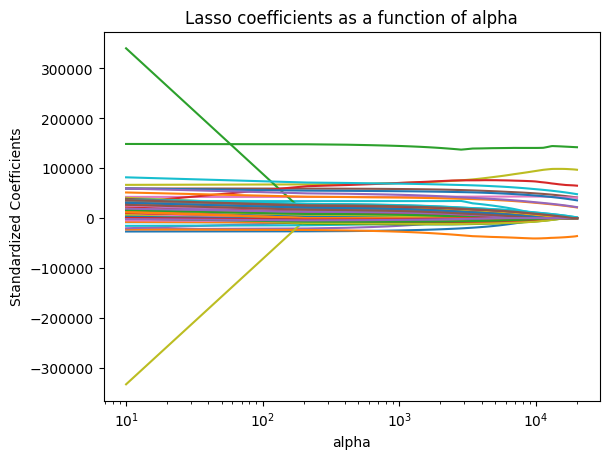

In [ ]:
alphas = np.linspace(10,20000,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

Mostrando os valores percorridos para escolher o alpha no lassocv:

In [ ]:
mse_per_fold = model_lasso_cv.mse_path_

# Calcular média das métricas para cada valor de alpha
mse_means = mse_per_fold.mean(axis=-1)

# Imprimir métricas
for i, alpha in enumerate(model_lasso_cv.alphas_):
    print(f"Alpha: {alpha}")
    print(f"Mean Squared Error (MSE) for each fold: {mse_per_fold[i]}")
    print(f"Mean MSE across folds: {mse_means[i]}")
    print("\n")

Alpha: 255754.50834533252
Mean Squared Error (MSE) for each fold: [1.46085217e+11 1.25757262e+11 1.52527535e+11 1.30504298e+11
 1.10100318e+11]
Mean MSE across folds: 132994926151.79314


Alpha: 238517.5104633295
Mean Squared Error (MSE) for each fold: [1.39047105e+11 1.17495468e+11 1.45524702e+11 1.22298069e+11
 1.03003699e+11]
Mean MSE across folds: 125473808884.46725


Alpha: 222442.22854835453
Mean Squared Error (MSE) for each fold: [1.30983987e+11 1.09786050e+11 1.37458358e+11 1.15153574e+11
 9.68577579e+10]
Mean MSE across folds: 118047945241.40202


Alpha: 207450.36683235757
Mean Squared Error (MSE) for each fold: [1.23936142e+11 1.03138407e+11 1.30404028e+11 1.08933003e+11
 9.15368915e+10]
Mean MSE across folds: 111589694429.13818


Alpha: 193468.9064200084
Mean Squared Error (MSE) for each fold: [1.17708836e+11 9.71333266e+10 1.23806872e+11 1.03386887e+11
 8.68913587e+10]
Mean MSE across folds: 105785455948.98564


Alpha: 180429.7496451363
Mean Squared Error (MSE) for each fol

### 10 execuções com o melhor alpha

In [36]:
from sklearn.model_selection import KFold

In [45]:
def GerarExecucoesValidacaoCruzada1(nome_modelo, modelo, data_X, data_y):
    num_execucoes = 1
    resultados_mse = []
    resultados_r2 = []
    resultados_mse_por_ex = []
    resultados_r2_por_ex = []

    for indice in range(num_execucoes):
        modelo = modelo
        cv_strategy = KFold(n_splits=10, shuffle=True, random_state=indice)
        scoring = ['neg_mean_squared_error', 'r2']
        cv_scores = cross_validate(modelo, data_X, data_y, scoring=scoring, cv=cv_strategy, n_jobs=-1)
        resultados_mse.append(np.mean(-cv_scores['test_neg_mean_squared_error']))
        resultados_r2.append(np.mean(cv_scores['test_r2']))

        # Calculando MSE para cada fold
        resultados_mse_por_ex.append((-cv_scores['test_neg_mean_squared_error']))
        resultados_r2_por_ex.append((cv_scores['test_r2']))

    # Convertendo a lista para uma matriz numpy para facilitar o cálculo do melhor e pior valor
    resultados_mse_por_ex = np.array(resultados_mse_por_ex)

    # Calculando melhor, pior e média por divisão
    melhor_valor_por_ex = np.min(resultados_mse_por_ex, axis=1)
    pior_valor_por_ex = np.max(resultados_mse_por_ex, axis=1)
    media_por_ex = np.mean(resultados_mse_por_ex, axis=1)

    print("Análise Comparativa do modelo para 10 execuções:", nome_modelo)
    print()

    print("Análise por execução:")
    print()
    for execucao, (melhor, pior, media) in enumerate(zip(melhor_valor_por_ex, pior_valor_por_ex, media_por_ex)):
        print(f"Por execução  {execucao + 1}: Melhor MSE - {melhor}, Pior MSE - {pior}, Média MSE - {media}")

    # Calculando métricas de análise comparativa
    print(resultados_mse_por_ex)
    media_mse = np.mean(resultados_mse_por_ex, axis=1)
    melhor_valor_mse = melhor_valor_por_ex
    pior_valor_mse = pior_valor_por_ex
    desvio_padrao_mse = np.std(resultados_mse_por_ex)

    media_r2 = np.mean(resultados_r2_por_ex, axis=1)
    melhor_valor_r2 = np.max(resultados_r2_por_ex, axis=1)
    pior_valor_r2 = np.min(resultados_r2_por_ex, axis=1)
    desvio_padrao_r2 = np.std(resultados_r2_por_ex, axis=1)

    print()
    print("Análise Geral:")
    print()

    print("----- MSE -----")
    print(f"Média: {media_mse}")
    print(f"Melhor encontrado: {melhor_valor_mse}")
    print(f"Pior encontrado: {pior_valor_mse}")
    print(f"Desvio Padrão: {desvio_padrao_mse}")
    print()

    print("----- Root MSE - RMSE - Para melhor entendimento -----")
    print(f"Média: {np.sqrt(media_mse)}")
    print(f"Melhor encontrado: {np.sqrt(melhor_valor_mse)}")
    print(f"Pior encontrado: {np.sqrt(pior_valor_mse)}")
    print(f"Desvio Padrão: {np.sqrt(desvio_padrao_mse)}")
    print()

    print("----- R^2 -----")
    print(f"Média: {media_r2}")
    print(f"Melhor encontrado: {melhor_valor_r2}")
    print(f"Pior encontrado: {pior_valor_r2}")
    print(f"Desvio Padrão: {desvio_padrao_r2}")

In [46]:
melhor_alpha = model_lasso_cv.alpha_
modelo = Lasso(alpha=melhor_alpha)

GerarExecucoesValidacaoCruzada1('Lasso', modelo, X_s, y)

Análise Comparativa do modelo para 10 execuções: Lasso

Análise por execução:

Por execução  1: Melhor MSE - 19745263376.310642, Pior MSE - 33350960834.60429, Média MSE - 26076227273.79005
[[2.28043420e+10 1.97452634e+10 2.91789636e+10 2.43338774e+10
  3.33509608e+10 3.06160171e+10 2.46555359e+10 2.90300831e+10
  2.66156548e+10 2.04315746e+10]]

Análise Geral:

----- MSE -----
Média: [2.60762273e+10]
Melhor encontrado: [1.97452634e+10]
Pior encontrado: [3.33509608e+10]
Desvio Padrão: 4241193785.0180798

----- Root MSE - RMSE - Para melhor entendimento -----
Média: [161481.35271229]
Melhor encontrado: [140517.84006421]
Pior encontrado: [182622.45435489]
Desvio Padrão: 65124.448443100686

----- R^2 -----
Média: [0.80736039]
Melhor encontrado: [0.82399198]
Pior encontrado: [0.78620012]
Desvio Padrão: [0.01167604]


In [ ]:
melhor_alpha = model_lasso_cv.alpha_
modelo = Lasso(alpha=melhor_alpha)

GerarExecucoesValidacaoCruzada('Lasso', modelo, X_s, y)

Análise Comparativa do modelo para 10 execuções: Lasso

Análise por execução:

Por execução  1: Melhor MSE - 19745263376.310642, Pior MSE - 33350960834.60429, Média MSE - 26076227273.79005
Por execução  2: Melhor MSE - 23274923227.648952, Pior MSE - 32724819358.908157, Média MSE - 25993389492.45284
Por execução  3: Melhor MSE - 20320421211.86646, Pior MSE - 37373762070.99152, Média MSE - 26095446712.98557
Por execução  4: Melhor MSE - 20355386612.63965, Pior MSE - 35509027034.012405, Média MSE - 26042066511.98664
Por execução  5: Melhor MSE - 19284969018.956017, Pior MSE - 42785558580.26512, Média MSE - 26112070528.651405
Por execução  6: Melhor MSE - 19701160032.00696, Pior MSE - 45976712402.07118, Média MSE - 26121424156.749252
Por execução  7: Melhor MSE - 19800739521.25198, Pior MSE - 38029037498.06979, Média MSE - 26077543550.056602
Por execução  8: Melhor MSE - 20703868625.428062, Pior MSE - 34630002407.80346, Média MSE - 26053421040.3238
Por execução  9: Melhor MSE - 21158722233

### Comportamento do alpha mais proximo de 10^4

Conforme visto no gráfico anterior, com o gráfico próximo de 10^4 muitos coeficientes são zerados. A fim de comparação, foi executado um modelo com esse valor de alpha.

Abaixo, temos novamente o gráfico que mostra mais claramente esse comportamento:

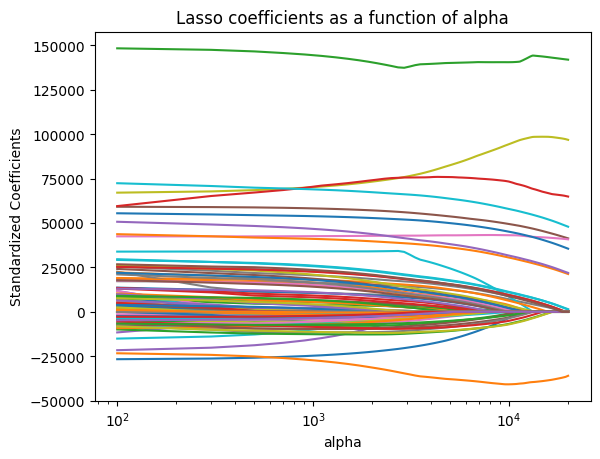

In [ ]:
alphas = np.linspace(100,20000,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

## modelo com o best alpha escolhido pelo LassoCV
Essa parte foi feita a fim de visualizar os coeficientes das features e plot da Learning Curve

In [ ]:
lasso_best = Lasso(alpha=model_lasso_cv.alpha_)
lasso_best.fit(X_train_scaled, y_train)

Lasso(alpha=255.7545083453325)

In [ ]:
print(list(zip(lasso_best.coef_, X)))

[(-26395.194540826804, 'bedrooms'), (18604.954725766627, 'bathrooms'), (147702.19559853763, 'sqft_living'), (8189.143622193736, 'sqft_lot'), (-20513.828629221774, 'floors'), (59021.668353969806, 'waterfront'), (42456.135806751685, 'view'), (17059.622573448985, 'condition'), (67627.96433005745, 'grade'), (33942.70688783101, 'sqft_above'), (0.0, 'sqft_basement'), (-24025.725063479567, 'yr_built'), (6652.029283905002, 'yr_renovated'), (64794.00594573946, 'lat'), (-7983.931809148406, 'long'), (7824.695586889712, 'sqft_living15'), (-1312.0621158669157, 'sqft_lot15'), (14084.766788757512, 'ano'), (0.0, 'renovada'), (-14162.116087419587, 'tem_porao'), (-1788.8894508179812, 'mes_2'), (3001.9172955849394, 'mes_3'), (5558.036105712239, 'mes_4'), (3189.378231208202, 'mes_5'), (3666.049223373593, 'mes_6'), (1878.0322264141196, 'mes_7'), (3919.6976203310346, 'mes_8'), (0.0, 'mes_9'), (2469.5935808910635, 'mes_10'), (3124.121337981341, 'mes_11'), (2137.349479635739, 'mes_12'), (2035.6904108904332, '

In [ ]:
coefficients = lasso_best.coef_
feature_names = np.array(['Feature_{}'.format(i) for i in range(1, X.shape[1] + 1)])

# Imprima os coeficientes e nomes das características
print(list(zip(coefficients, feature_names)))

# Contando coeficientes diferentes de zero
nonzero_count = np.count_nonzero(coefficients)
print("Número de coeficientes diferentes de zero:", nonzero_count)

[(-26395.194540826804, 'Feature_1'), (18604.954725766627, 'Feature_2'), (147702.19559853763, 'Feature_3'), (8189.143622193736, 'Feature_4'), (-20513.828629221774, 'Feature_5'), (59021.668353969806, 'Feature_6'), (42456.135806751685, 'Feature_7'), (17059.622573448985, 'Feature_8'), (67627.96433005745, 'Feature_9'), (33942.70688783101, 'Feature_10'), (0.0, 'Feature_11'), (-24025.725063479567, 'Feature_12'), (6652.029283905002, 'Feature_13'), (64794.00594573946, 'Feature_14'), (-7983.931809148406, 'Feature_15'), (7824.695586889712, 'Feature_16'), (-1312.0621158669157, 'Feature_17'), (14084.766788757512, 'Feature_18'), (0.0, 'Feature_19'), (-14162.116087419587, 'Feature_20'), (-1788.8894508179812, 'Feature_21'), (3001.9172955849394, 'Feature_22'), (5558.036105712239, 'Feature_23'), (3189.378231208202, 'Feature_24'), (3666.049223373593, 'Feature_25'), (1878.0322264141196, 'Feature_26'), (3919.6976203310346, 'Feature_27'), (0.0, 'Feature_28'), (2469.5935808910635, 'Feature_29'), (3124.121337

ficaram 97 variáveis

In [ ]:
# Supondo que lasso_best.coef_ é uma lista de coeficientes e X é uma lista de nomes de características
coeficientes_ordenados = sorted(zip(lasso_best.coef_, X), key=lambda x: abs(x[0]), reverse=True)

for coef, feature_name in coeficientes_ordenados:
    print(f"Coeficiente: {coef}, Característica: {feature_name}")


Coeficiente: 147702.19559853763, Característica: sqft_living
Coeficiente: 70970.96897309019, Característica: zipcode_98004
Coeficiente: 67627.96433005745, Característica: grade
Coeficiente: 64794.00594573946, Característica: lat
Coeficiente: 59021.668353969806, Característica: waterfront
Coeficiente: 54884.885060303925, Característica: zipcode_98039
Coeficiente: 49311.490493835285, Característica: zipcode_98112
Coeficiente: 42629.96717734995, Característica: zipcode_98040
Coeficiente: 42456.135806751685, Característica: view
Coeficiente: 33942.70688783101, Característica: sqft_above
Coeficiente: 28218.754572606325, Característica: zipcode_98105
Coeficiente: 28170.227101659253, Característica: zipcode_98119
Coeficiente: -26395.194540826804, Característica: bedrooms
Coeficiente: 25579.092129744993, Característica: zipcode_98199
Coeficiente: 24701.16408129714, Característica: zipcode_98102
Coeficiente: 24392.932654439224, Característica: zipcode_98109
Coeficiente: 24329.905719579023, Cara

#### Avaliação

In [ ]:
print('R squared training set', round(lasso_best.score(X_train_scaled, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test_scaled, y_test)*100, 2))

R squared training set 80.93
R squared test set 81.16


In [ ]:

mse= mean_squared_error(y_test, lasso_best.predict(X_test_scaled))
mse

26037640705.24998

In [ ]:
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 161361.83162461309


In [ ]:
mae = mean_absolute_error(y_test, lasso_best.predict(X_test_scaled))
print("Mean Absolute Error:", mae)

Mean Absolute Error: 96643.41379079426


### MSE em relação aos alphas por fold

<ipython-input-424-cdf5ea760db9>:22: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(xmin, xmax);


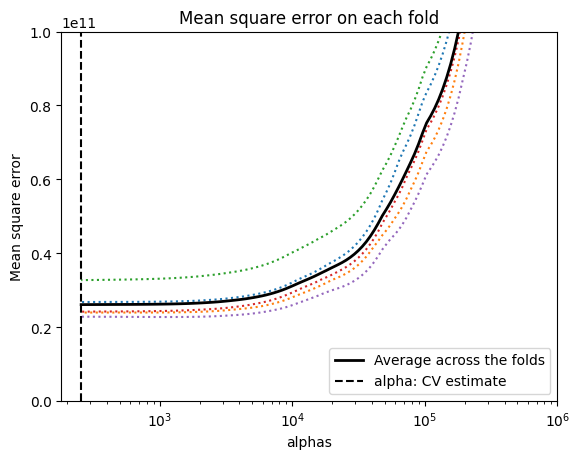

In [ ]:
plt.semilogx(model_lasso_cv.alphas_, model_lasso_cv.mse_path_, ":")
plt.plot(
    model_lasso_cv.alphas_ ,
    model_lasso_cv.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model_lasso_cv.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = -100, 100000000000
xmin, xmax = -10000, 1000000
plt.ylim(ymin, ymax);
plt.xlim(xmin, xmax);

## Função learning curve


- **Curva de aprendizado de treinamento (Train Learning Curve)**: Curva de aprendizado calculada a partir do conjunto de dados de treinamento que dá uma ideia de quão bem o modelo está aprendendo.
- **Curva de aprendizagem de validação (Validation Learning Curve)**: Curva de aprendizagem calculada a partir de um conjunto de dados de teste que dá uma ideia de quão bem o modelo está generalizando.


In [51]:
from sklearn.model_selection import learning_curve

In [52]:
def plot_learning_curve(model, X, y,model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.01, 1.0, 50), scoring='neg_mean_squared_error', cv=10,verbose=1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    train_scores_std =-np.std(train_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Validation Score')

    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color='#ddeae6', alpha=0.9)
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,color='#f7ffb4', alpha=0.5)

    plt.xlabel('Training Set Size')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.show()



[learning_curve] Training set sizes: [  192   582   972  1362  1752  2141  2531  2921  3311  3700  4090  4480
  4870  5260  5649  6039  6429  6819  7208  7598  7988  8378  8768  9157
  9547  9937 10327 10716 11106 11496 11886 12276 12665 13055 13445 13835
 14224 14614 15004 15394 15784 16173 16563 16953 17343 17732 18122 18512
 18902 19292]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e+10, tolerance: 2.948e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+11, tolerance: 1.185e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.647e+11, tolerance: 2.130e

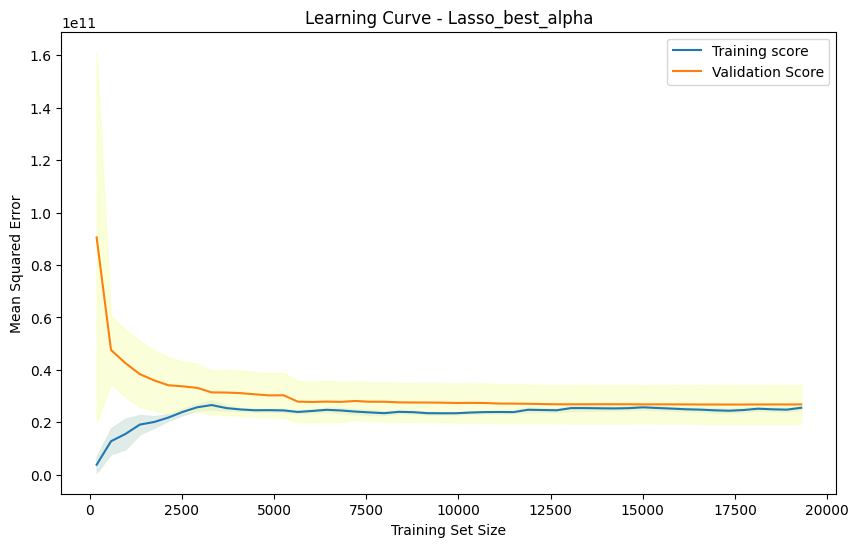

In [ ]:
plot_learning_curve(lasso_best, X_s, y, model_name="Lasso_best_alpha")

O erro no treinamento é baixo ao usar poucas amostras para treinamento e aumenta ao aumentar as amostras, enquanto para teste é alto no inicio e depois diminui ao adicionar mais amostras.

## Learning curve relação a r^2

In [53]:
def plot_learning_curve_r2(model, X, y,model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.01, 1.0, 50), scoring='r2', cv=10,verbose=1)

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    train_scores_std =np.std(train_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Validation Score')

    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,color='#ddeae6', alpha =0.5)
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,color='#f7ffb4',alpha =0.8)

    plt.xlabel('Training Set Size')
    plt.ylabel('r2')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.show()



[learning_curve] Training set sizes: [  192   582   972  1362  1752  2141  2531  2921  3311  3700  4090  4480
  4870  5260  5649  6039  6429  6819  7208  7598  7988  8378  8768  9157
  9547  9937 10327 10716 11106 11496 11886 12276 12665 13055 13445 13835
 14224 14614 15004 15394 15784 16173 16563 16953 17343 17732 18122 18512
 18902 19292]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e+10, tolerance: 2.948e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e+11, tolerance: 1.185e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.647e+11, tolerance: 2.130e

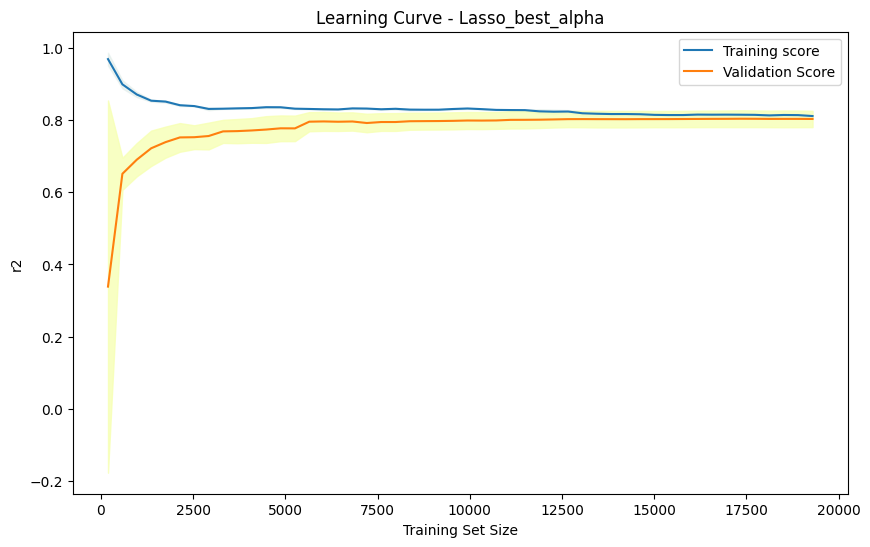

In [ ]:
plot_learning_curve_r2(lasso_best, X_s, y, model_name="Lasso_best_alpha")

A pontuação de treinamento é alta ao usar poucas amostras para treinamento e diminui ao aumentar as amostras, enquanto para teste é baixa no inicio e depois aumenta ao adicionar mais amostras.

## Usando valor observado no grafico

### 10 Execuções Lasso alpha  = 10^4

In [48]:
modelo = Lasso(alpha=10000)

GerarExecucoesValidacaoCruzada1('Lasso Alpha 10^4', modelo, X_s, y)

Análise Comparativa do modelo para 10 execuções: Lasso Alpha 10^4

Análise por execução:

Por execução  1: Melhor MSE - 23355882281.618477, Pior MSE - 39903865009.831856, Média MSE - 31127434393.83977
[[2.56555713e+10 2.33558823e+10 3.53254311e+10 2.90198224e+10
  3.99038650e+10 3.69290757e+10 2.94868849e+10 3.46321177e+10
  3.20768798e+10 2.48888136e+10]]

Análise Geral:

----- MSE -----
Média: [3.11274344e+10]
Melhor encontrado: [2.33558823e+10]
Pior encontrado: [3.9903865e+10]
Desvio Padrão: 5271473538.4402895

----- Root MSE - RMSE - Para melhor entendimento -----
Média: [176429.6868269]
Melhor encontrado: [152826.31410074]
Pior encontrado: [199759.51794553]
Desvio Padrão: 72604.91401028095

----- R^2 -----
Média: [0.77021391]
Melhor encontrado: [0.78950252]
Pior encontrado: [0.74211433]
Desvio Padrão: [0.01545429]


In [ ]:
modelo = Lasso(alpha=10000)

GerarExecucoesValidacaoCruzada('Lasso Alpha 10^4', modelo, X_s, y)

Análise Comparativa do modelo para 10 execuções: Lasso Alpha 10^4

Análise por execução:

Por execução  1: Melhor MSE - 23355882281.618477, Pior MSE - 39903865009.831856, Média MSE - 31127434393.83977
Por execução  2: Melhor MSE - 27126255678.281822, Pior MSE - 40674253538.85455, Média MSE - 31031074699.08326
Por execução  3: Melhor MSE - 24020094376.250343, Pior MSE - 44068230410.69672, Média MSE - 31155911741.472984
Por execução  4: Melhor MSE - 23676958476.135204, Pior MSE - 41939402969.710526, Média MSE - 31053475648.327553
Por execução  5: Melhor MSE - 22478296785.53628, Pior MSE - 51978856410.5288, Média MSE - 31126495769.197533
Por execução  6: Melhor MSE - 23689278494.8512, Pior MSE - 54848263781.08651, Média MSE - 31163158123.466225
Por execução  7: Melhor MSE - 23626461799.816696, Pior MSE - 46507056490.523094, Média MSE - 31155677160.75479
Por execução  8: Melhor MSE - 24743747434.17909, Pior MSE - 41372524155.8271, Média MSE - 31086924886.010048
Por execução  9: Melhor MSE 

In [ ]:
lasso_best_eu = Lasso(alpha=10000)
lasso_best_eu.fit(X_train_scaled, y_train)
print(list(zip(lasso_best_eu.coef_, X)))
coefficients_2 = lasso_best_eu.coef_
feature_names_2 = np.array(['Feature_{}'.format(i) for i in range(1, X.shape[1] + 1)])

# Imprima os coeficientes e nomes das características
print(list(zip(coefficients_2, feature_names_2)))

# Contando coeficientes diferentes de zero
nonzero_count_2 = np.count_nonzero(coefficients_2)
print("Número de coeficientes diferentes de zero:", nonzero_count_2)
print('R squared training set', round(lasso_best_eu.score(X_train_scaled, y_train)*100, 2))
print('R squared test set', round(lasso_best_eu.score(X_test_scaled, y_test)*100, 2))
mse= mean_squared_error(y_test, lasso_best_eu.predict(X_test_scaled))
print("MSE:",mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)
mae = mean_absolute_error(y_test, lasso_best_eu.predict(X_test_scaled))
print("Mean Absolute Error:", mae)

[(-3298.584410855587, 'bedrooms'), (3804.290731503636, 'bathrooms'), (140556.20195049015, 'sqft_living'), (0.0, 'sqft_lot'), (0.0, 'floors'), (49428.18988739083, 'waterfront'), (43129.42352397838, 'view'), (7037.962091637427, 'condition'), (94430.37784864858, 'grade'), (8448.668306017527, 'sqft_above'), (0.0, 'sqft_basement'), (-40813.38132870279, 'yr_built'), (0.0, 'yr_renovated'), (73293.34756486684, 'lat'), (-0.0, 'long'), (0.0, 'sqft_living15'), (-0.0, 'sqft_lot15'), (2081.4777259091065, 'ano'), (0.0, 'renovada'), (-0.0, 'tem_porao'), (-0.0, 'mes_2'), (0.0, 'mes_3'), (0.0, 'mes_4'), (0.0, 'mes_5'), (-0.0, 'mes_6'), (-0.0, 'mes_7'), (-0.0, 'mes_8'), (-0.0, 'mes_9'), (-0.0, 'mes_10'), (-0.0, 'mes_11'), (-0.0, 'mes_12'), (0.0, 'dia_semana_1'), (-0.0, 'dia_semana_2'), (-0.0, 'dia_semana_3'), (0.0, 'dia_semana_4'), (0.0, 'dia_semana_5'), (-0.0, 'dia_semana_6'), (0.0, 'zipcode_98002'), (-0.0, 'zipcode_98003'), (57874.45537203412, 'zipcode_98004'), (0.0, 'zipcode_98005'), (6183.0114836854

### Coeficientes

In [ ]:
# Supondo que lasso_best.coef_ é uma lista de coeficientes e X é uma lista de nomes de características
coeficientes_ordenados = sorted(zip(lasso_best_eu.coef_, X), key=lambda x: abs(x[0]), reverse=True)

for coef, feature_name in coeficientes_ordenados:
    print(f"Coeficiente: {coef}, Característica: {feature_name}")


Coeficiente: 140556.20195049015, Característica: sqft_living
Coeficiente: 94430.37784864858, Característica: grade
Coeficiente: 73293.34756486684, Característica: lat
Coeficiente: 57874.45537203412, Característica: zipcode_98004
Coeficiente: 49428.18988739083, Característica: waterfront
Coeficiente: 45093.29514132832, Característica: zipcode_98039
Coeficiente: 43129.42352397838, Característica: view
Coeficiente: -40813.38132870279, Característica: yr_built
Coeficiente: 31653.002737472947, Característica: zipcode_98112
Coeficiente: 30537.353466232897, Característica: zipcode_98040
Coeficiente: 11209.208895626803, Característica: zipcode_98119
Coeficiente: 10931.454108534313, Característica: zipcode_98105
Coeficiente: 9573.499339696096, Característica: zipcode_98102
Coeficiente: 9381.439840129746, Característica: zipcode_98109
Coeficiente: 8845.465882834951, Característica: zipcode_98033
Coeficiente: 8697.85216044653, Característica: zipcode_98199
Coeficiente: 8448.668306017527, Caracter

[learning_curve] Training set sizes: [  192   582   972  1362  1752  2141  2531  2921  3311  3700  4090  4480
  4870  5260  5649  6039  6429  6819  7208  7598  7988  8378  8768  9157
  9547  9937 10327 10716 11106 11496 11886 12276 12665 13055 13445 13835
 14224 14614 15004 15394 15784 16173 16563 16953 17343 17732 18122 18512
 18902 19292]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   25.6s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   59.3s


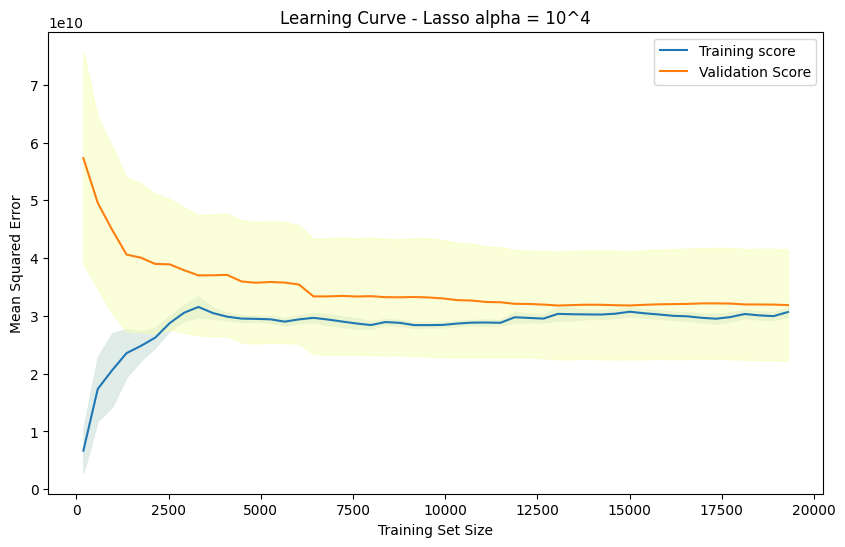

In [ ]:
plot_learning_curve(lasso_best_eu, X_s, y, model_name="Lasso alpha = 10^4")

[learning_curve] Training set sizes: [  192   582   972  1362  1752  2141  2531  2921  3311  3700  4090  4480
  4870  5260  5649  6039  6429  6819  7208  7598  7988  8378  8768  9157
  9547  9937 10327 10716 11106 11496 11886 12276 12665 13055 13445 13835
 14224 14614 15004 15394 15784 16173 16563 16953 17343 17732 18122 18512
 18902 19292]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   19.4s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:   43.3s


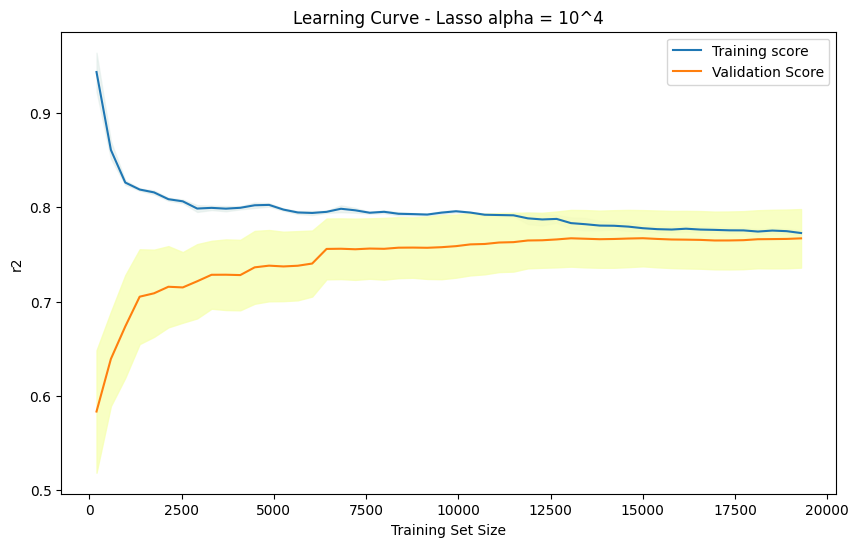

In [ ]:
plot_learning_curve_r2(lasso_best_eu, X_s, y, model_name="Lasso alpha = 10^4")

 Aqui vemos a influência do alpha maior:
 Resulta em menor variância, mas maior viés.

 - Um modelo com alto viés tende a simplificar demais a realidade e pode não capturar padrões complexos nos dados. Podemos ver que além do erro ter ficado maior, o desvio tbm ficou bem maior

 - Um modelo com alta variância é muito sensível às flutuações nos dados de treinamento e pode se ajustar demais a essas flutuações, capturando padrões específicos dos dados

# Modelo 2: XGboost
O nome XGBoost vem de extreme *Gradient Boosting, e
representa uma categoria de algoritmo baseada em Decision Trees
(árvores de decisão) com Gradient Boosting (aumento de gradiente)

### 10 execuções XG

In [55]:
GerarExecucoesValidacaoCruzada1('XGBRegressor', modelo, X_s, y)

Análise Comparativa do modelo para 10 execuções: XGBRegressor

Análise por execução:

Por execução  1: Melhor MSE - 11502953053.42219, Pior MSE - 23517913853.735146, Média MSE - 16283449148.572483
[[1.19603643e+10 1.42973840e+10 1.48448544e+10 1.46074315e+10
  2.35179139e+10 2.20156934e+10 2.30615585e+10 1.34528839e+10
  1.35734546e+10 1.15029531e+10]]

Análise Geral:

----- MSE -----
Média: [1.62834491e+10]
Melhor encontrado: [1.15029531e+10]
Pior encontrado: [2.35179139e+10]
Desvio Padrão: 4436894089.070637

----- Root MSE - RMSE - Para melhor entendimento -----
Média: [127606.61874908]
Melhor encontrado: [107251.82074642]
Pior encontrado: [153355.51458534]
Desvio Padrão: 66610.01493071922

----- R^2 -----
Média: [0.87991252]
Melhor encontrado: [0.91307071]
Pior encontrado: [0.83537088]
Desvio Padrão: [0.0250387]


In [49]:
modelo = XGBRegressor()

GerarExecucoesValidacaoCruzada('XGBRegressor', modelo, X_s, y)

Análise Comparativa do modelo para 10 execuções: XGBRegressor

Análise por execução:

Por execução  1: Melhor MSE - 11502953053.42219, Pior MSE - 23517913853.735146, Média MSE - 16283449148.572483
Por execução  2: Melhor MSE - 10664409407.270802, Pior MSE - 18796206856.833195, Média MSE - 14540372021.089132
Por execução  3: Melhor MSE - 12411850613.72142, Pior MSE - 22481453610.602474, Média MSE - 16194922073.583221
Por execução  4: Melhor MSE - 11151998659.682985, Pior MSE - 20556400077.144184, Média MSE - 15225424185.125513
Por execução  5: Melhor MSE - 10771518762.292112, Pior MSE - 30207144827.524036, Média MSE - 15395582433.344412
Por execução  6: Melhor MSE - 10687520944.666492, Pior MSE - 30857370451.059605, Média MSE - 15914915353.868067
Por execução  7: Melhor MSE - 12093699945.540977, Pior MSE - 23713901531.50925, Média MSE - 15418348316.05095
Por execução  8: Melhor MSE - 12094466382.050457, Pior MSE - 20733648289.050697, Média MSE - 15406260136.825033
Por execução  9: Melho

[learning_curve] Training set sizes: [  192   582   972  1362  1752  2141  2531  2921  3311  3700  4090  4480
  4870  5260  5649  6039  6429  6819  7208  7598  7988  8378  8768  9157
  9547  9937 10327 10716 11106 11496 11886 12276 12665 13055 13445 13835
 14224 14614 15004 15394 15784 16173 16563 16953 17343 17732 18122 18512
 18902 19292]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   46.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.6min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  5.6min


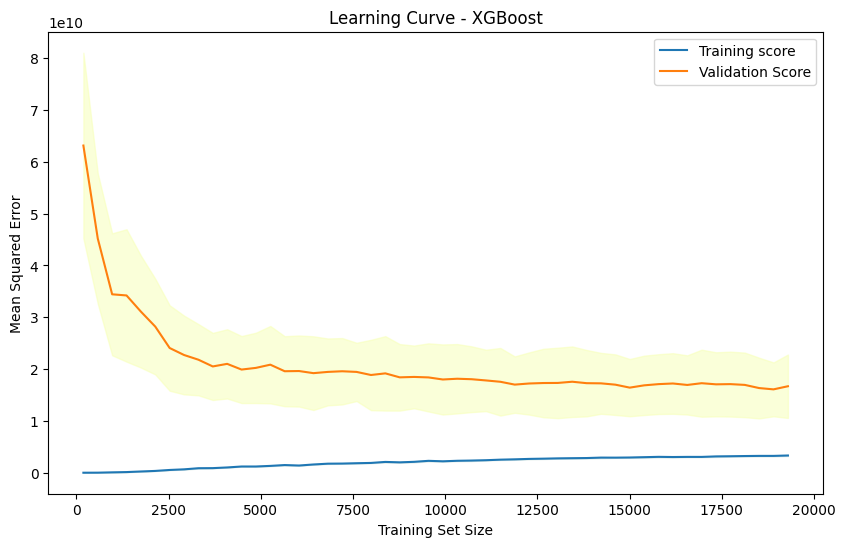

In [56]:
plot_learning_curve(modelo, X_s, y, model_name="XGBoost")

[learning_curve] Training set sizes: [  192   582   972  1362  1752  2141  2531  2921  3311  3700  4090  4480
  4870  5260  5649  6039  6429  6819  7208  7598  7988  8378  8768  9157
  9547  9937 10327 10716 11106 11496 11886 12276 12665 13055 13445 13835
 14224 14614 15004 15394 15784 16173 16563 16953 17343 17732 18122 18512
 18902 19292]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   35.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  2.4min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  5.3min


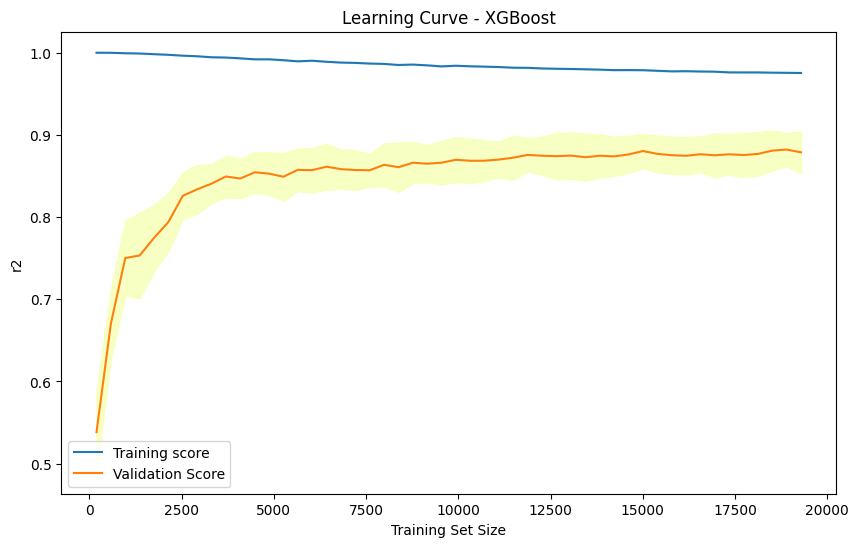

In [57]:
plot_learning_curve_r2(modelo, X_s, y, model_name="XGBoost")

A pontuação de treinamento permanece alta independentemente do tamanho do conjunto de treinamento. Por outro lado, a pontuação do teste aumenta com o tamanho do conjunto de dados de treinamento. Na verdade, aumenta até um ponto em que atinge um patamar. Observar tal patamar é uma indicação de que pode não ser útil adquirir novos dados para treinar o modelo, uma vez que o desempenho de generalização do modelo não aumentará mais.



In [ ]:

regressor_xgboost = XGBRegressor(n_estimators=1000, random_state=0)
#treinando o modelo
regressor_xgboost.fit(X_train_scaled, y_train)

y_pred_xgboost = regressor_xgboost.predict(X_test_scaled)
#avaliando o modelo
print("MAE: ", mean_absolute_error(y_test, y_pred_xgboost))
print("MSE: ", mean_squared_error(y_test, y_pred_xgboost))
print("R2: ", r2_score(y_test, y_pred_xgboost))


# Modelo 3: CatBoostRegressor

Categorial Boosting

O algoritmo é uma implementação de gradient boosting que utiliza árvores de decisão binárias como preditores base. Durante o treinamento, ele constrói um conjunto de árvores de decisão de forma iterativa. Cada árvore subsequente é construída com o objetivo de reduzir a perda em comparação com as árvores anteriores.

O CatBoost se destaca por sua implementação de árvores simétricas (também chamadas de árvores oblivious). No contexto do CatBoost, "oblivious" significa que o mesmo critério de divisão é aplicado em todo o nível da árvore. Essas árvores são balanceadas e menos propensas ao overfitting, o que contribui para um desempenho mais eficiente durante a fase de teste do modelo. Essa abordagem melhora significativamente a velocidade de execução do modelo.

"    **WARNING**

  **Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality."**

Ou seja, para esse modelo não usaremos one-hot encoding do mês, dia da semana, zipcode e as criadas "tem porão" e "foi renovada". Na sessão de divisão de features e target isso foi levado em consideração

In [34]:
X_catboost_train, X_catboost_test, y_catboost_train, y_catboost_test = train_test_split(X, y, test_size=0.25, random_state=42)
standard_scaler = StandardScaler()
X_catboost_train_scaled = standard_scaler.fit_transform(X_catboost_train)
X_catboost_test_scaled = standard_scaler.transform(X_catboost_test)

Será usada a classe GridSearchCV do scikit-learn para realizar uma busca em grade (grid search) de hiperparâmetros para um modelo CatBoostRegressor e achar os melhores



In [ ]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cat = cb.CatBoostRegressor(loss_function='RMSE')
Grid_CBC = GridSearchCV(estimator=model_cat, param_grid = grid, cv = 5, n_jobs=-1)
Grid_CBC.fit(X_catboost_train_scaled, y_catboost_train)

0:	learn: 339563.8476759	total: 18.6ms	remaining: 3.7s
1:	learn: 317653.7209250	total: 32.8ms	remaining: 3.25s
2:	learn: 298105.1263423	total: 45.5ms	remaining: 2.99s
3:	learn: 279438.6703159	total: 58.7ms	remaining: 2.88s
4:	learn: 263313.8697197	total: 71.9ms	remaining: 2.8s
5:	learn: 247774.0299133	total: 84.9ms	remaining: 2.74s
6:	learn: 234676.4944917	total: 97.7ms	remaining: 2.69s
7:	learn: 223672.9688537	total: 111ms	remaining: 2.67s
8:	learn: 212194.9002623	total: 125ms	remaining: 2.65s
9:	learn: 202956.2450368	total: 138ms	remaining: 2.62s
10:	learn: 193920.8598809	total: 151ms	remaining: 2.6s
11:	learn: 186250.3864307	total: 165ms	remaining: 2.59s
12:	learn: 178576.6563999	total: 179ms	remaining: 2.57s
13:	learn: 172530.1906868	total: 195ms	remaining: 2.59s
14:	learn: 167022.9868685	total: 208ms	remaining: 2.56s
15:	learn: 161618.0035685	total: 227ms	remaining: 2.61s
16:	learn: 157390.5971281	total: 240ms	remaining: 2.59s
17:	learn: 153019.9400621	total: 253ms	remaining: 2.56

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7c06aa224880>,
             n_jobs=-1,
             param_grid={'depth': [2, 4, 6, 8], 'iterations': [100, 150, 200],
                         'l2_leaf_reg': [0.2, 0.5, 1, 3],
                         'learning_rate': [0.03, 0.1]})

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:

 The best score across ALL searched params:
 0.8916456088752465

 The best parameters across ALL searched params:
 {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 0.5, 'learning_rate': 0.1}


In [35]:
modelo_cat = cb.CatBoostRegressor(iterations=200,
                              learning_rate=0.1,
                              depth=8,
                              l2_leaf_reg=0.5,
                              loss_function='RMSE')
modelo_cat.fit(X_catboost_train_scaled,y_catboost_train,verbose=0)

In [38]:
X_catboost

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,zipcode,lat,long,sqft_living15,sqft_lot15,ano,mes,dia_semana,renovada,tem_porao
0,6,3.00,2400,9373,2.0,0,0,3,7,2400,...,98002,47.3262,-122.214,2060,7316,2015,4,2,0,0
1,4,1.75,2060,26036,1.0,0,0,4,8,1160,...,98166,47.4444,-122.351,2590,21891,2014,5,3,0,1
2,3,1.00,1460,43000,1.0,0,0,3,7,1460,...,98166,47.4434,-122.347,2250,20023,2014,8,0,0,0
3,3,1.00,1430,7599,1.5,0,0,4,6,1010,...,98168,47.4783,-122.265,1290,10320,2015,4,2,0,1
4,4,2.00,1650,3504,1.0,0,0,3,7,760,...,98144,47.5803,-122.294,1480,3504,2015,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21431,5,2.00,1600,4168,1.5,0,0,3,7,1600,...,98126,47.5297,-122.381,1190,4168,2014,7,4,0,0
21432,2,1.00,1040,7372,1.0,0,0,5,7,840,...,98126,47.5285,-122.378,1930,5150,2015,3,2,0,1
21433,3,1.00,1100,4128,1.0,0,0,4,7,720,...,98126,47.5296,-122.379,1510,4538,2014,6,1,0,1
21434,2,1.75,1410,1005,1.5,0,0,3,9,900,...,98027,47.5446,-122.018,1440,1188,2014,7,3,0,1


### Gráfico de importância variável
Apenas as 25 primeiras

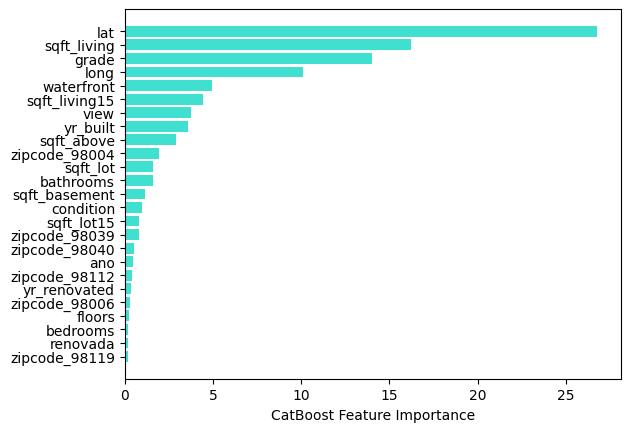

In [36]:
num_features_to_show = 25

sorted_feature_importance = modelo_cat.feature_importances_.argsort()
top_feature_indices = sorted_feature_importance[-num_features_to_show:]

plt.barh(X.columns[top_feature_indices],
         modelo_cat.feature_importances_[top_feature_indices],
         color='turquoise')
plt.xlabel("CatBoost Feature Importance")
plt.show()

### 10 Execuçoes catboost

In [62]:
GerarExecucoesValidacaoCruzada1('CatBoostRegressor', modelo_cat, X_catboost_scaled, y_catboost)

Análise Comparativa do modelo para 10 execuções: CatBoostRegressor

Análise por execução:

Por execução  1: Melhor MSE - 9939783710.005266, Pior MSE - 19099918804.54018, Média MSE - 13532770831.866436
[[1.16485102e+10 1.06836376e+10 1.45303096e+10 1.27321188e+10
  1.90999188e+10 1.76652972e+10 1.40090845e+10 1.28655948e+10
  1.21534531e+10 9.93978371e+09]]

Análise Geral:

----- MSE -----
Média: [1.35327708e+10]
Melhor encontrado: [9.93978371e+09]
Pior encontrado: [1.90999188e+10]
Desvio Padrão: 2772347541.9632955

----- Root MSE - RMSE - Para melhor entendimento -----
Média: [116330.43811431]
Melhor encontrado: [99698.46393002]
Pior encontrado: [138202.45585568]
Desvio Padrão: 52653.08672778164

----- R^2 -----
Média: [0.90017196]
Melhor encontrado: [0.91686563]
Pior encontrado: [0.87663848]
Desvio Padrão: [0.01171248]


In [ ]:
modelo_cat = cb.CatBoostRegressor(iterations=200,
                              learning_rate=0.1,
                              depth=8,
                              l2_leaf_reg=0.5,
                              loss_function='RMSE')

GerarExecucoesValidacaoCruzada('CatBoostRegressor', modelo_cat, X_catboost_scaled, y_catboost)

Análise Comparativa do modelo para 10 execuções: CatBoostRegressor

Análise por Fold:

Por execução e fold 1: Melhor MSE - 9939783710.005266, Pior MSE - 19099918804.54018, Média MSE - 13532770831.866436
Por execução e fold 2: Melhor MSE - 10456325733.937336, Pior MSE - 18997566172.17258, Média MSE - 13328777710.742342
Por execução e fold 3: Melhor MSE - 10190739671.456402, Pior MSE - 19318359289.083115, Média MSE - 13441696694.937452
Por execução e fold 4: Melhor MSE - 9346574042.348309, Pior MSE - 20141438377.59306, Média MSE - 13193642648.585894
Por execução e fold 5: Melhor MSE - 10470537269.847054, Pior MSE - 26102119107.602074, Média MSE - 13440173769.970196
Por execução e fold 6: Melhor MSE - 10065008310.835052, Pior MSE - 28386802048.633526, Média MSE - 13513493110.834597
Por execução e fold 7: Melhor MSE - 11139574514.81307, Pior MSE - 19837450180.571526, Média MSE - 12963737514.863361
Por execução e fold 8: Melhor MSE - 10627510388.213278, Pior MSE - 20376272989.609776, Média 

A saída de streaming foi truncada nas últimas 5000 linhas.
0:	learn: 348928.5016937	total: 16ms	remaining: 3.17s
1:	learn: 324344.8866211	total: 43.4ms	remaining: 4.29s
2:	learn: 303813.0434929	total: 74.7ms	remaining: 4.91s
3:	learn: 285183.3026722	total: 103ms	remaining: 5.07s
4:	learn: 267604.5384668	total: 130ms	remaining: 5.06s
5:	learn: 252635.2474501	total: 153ms	remaining: 4.96s
6:	learn: 237904.4190269	total: 180ms	remaining: 4.97s
7:	learn: 225248.4155171	total: 207ms	remaining: 4.97s
8:	learn: 213356.2631341	total: 233ms	remaining: 4.94s
9:	learn: 203148.0794600	total: 259ms	remaining: 4.91s
10:	learn: 194337.3392115	total: 284ms	remaining: 4.88s
11:	learn: 186330.5820529	total: 314ms	remaining: 4.92s
12:	learn: 179515.7094315	total: 342ms	remaining: 4.91s
13:	learn: 171965.7025902	total: 368ms	remaining: 4.89s
14:	learn: 166040.0222302	total: 389ms	remaining: 4.8s
15:	learn: 160924.9094214	total: 417ms	remaining: 4.79s
16:	learn: 156798.2802602	total: 440ms	remaining: 4.74s

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.8min


A saída de streaming foi truncada nas últimas 5000 linhas.
0:	learn: 354031.1415166	total: 14.3ms	remaining: 2.84s
1:	learn: 328936.5626665	total: 36.8ms	remaining: 3.65s
2:	learn: 308036.9512518	total: 66ms	remaining: 4.34s
3:	learn: 289584.5932205	total: 92.4ms	remaining: 4.53s
4:	learn: 271557.0788117	total: 127ms	remaining: 4.94s
5:	learn: 256522.7136363	total: 150ms	remaining: 4.85s
6:	learn: 241385.6546570	total: 172ms	remaining: 4.75s
7:	learn: 228930.2229473	total: 194ms	remaining: 4.65s
8:	learn: 216365.6425309	total: 217ms	remaining: 4.61s
9:	learn: 206062.9100354	total: 241ms	remaining: 4.58s
10:	learn: 197027.3806684	total: 264ms	remaining: 4.53s
11:	learn: 188621.6512829	total: 288ms	remaining: 4.51s
12:	learn: 181456.1810843	total: 310ms	remaining: 4.46s
13:	learn: 173876.0613353	total: 340ms	remaining: 4.52s
14:	learn: 167923.5779503	total: 367ms	remaining: 4.52s
15:	learn: 162585.7060926	total: 388ms	remaining: 4.46s
16:	learn: 158074.1956989	total: 409ms	remaining: 4.4

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed: 11.0min


A saída de streaming foi truncada nas últimas 5000 linhas.
7:	learn: 223890.4395593	total: 97.5ms	remaining: 2.34s
8:	learn: 212521.2438825	total: 108ms	remaining: 2.3s
9:	learn: 202744.0480287	total: 119ms	remaining: 2.25s
10:	learn: 194051.8249486	total: 129ms	remaining: 2.22s
11:	learn: 185766.0444654	total: 140ms	remaining: 2.2s
12:	learn: 178866.5641322	total: 151ms	remaining: 2.17s
13:	learn: 172304.5036735	total: 161ms	remaining: 2.15s
14:	learn: 165967.1053492	total: 172ms	remaining: 2.12s
15:	learn: 161146.0382999	total: 198ms	remaining: 2.27s
16:	learn: 156512.2936744	total: 216ms	remaining: 2.33s
17:	learn: 152051.7143818	total: 236ms	remaining: 2.38s
18:	learn: 148404.7671173	total: 248ms	remaining: 2.36s
19:	learn: 144349.1424092	total: 258ms	remaining: 2.32s
20:	learn: 141555.0748142	total: 268ms	remaining: 2.29s
21:	learn: 138936.3189822	total: 279ms	remaining: 2.26s
22:	learn: 136087.8352057	total: 289ms	remaining: 2.23s
23:	learn: 133701.7483991	total: 300ms	remaining:

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed: 24.2min


A saída de streaming foi truncada nas últimas 5000 linhas.
0:	learn: 349040.4279789	total: 10.8ms	remaining: 2.16s
1:	learn: 325032.8703466	total: 22.6ms	remaining: 2.23s
2:	learn: 304014.7654485	total: 33.1ms	remaining: 2.17s
3:	learn: 285441.7570122	total: 43.7ms	remaining: 2.14s
4:	learn: 267957.7702778	total: 54.5ms	remaining: 2.13s
5:	learn: 253284.8084534	total: 65ms	remaining: 2.1s
6:	learn: 238721.2830218	total: 75.1ms	remaining: 2.07s
7:	learn: 226537.1024612	total: 85.3ms	remaining: 2.05s
8:	learn: 215329.3686189	total: 95.5ms	remaining: 2.03s
9:	learn: 204684.4880134	total: 106ms	remaining: 2.02s
10:	learn: 195927.6216005	total: 117ms	remaining: 2.01s
11:	learn: 188032.6179952	total: 127ms	remaining: 1.99s
12:	learn: 180946.4989944	total: 138ms	remaining: 1.98s
13:	learn: 173671.4057940	total: 148ms	remaining: 1.97s
14:	learn: 167655.3048124	total: 158ms	remaining: 1.95s
15:	learn: 162853.0075311	total: 169ms	remaining: 1.95s
16:	learn: 158036.8601985	total: 184ms	remaining:

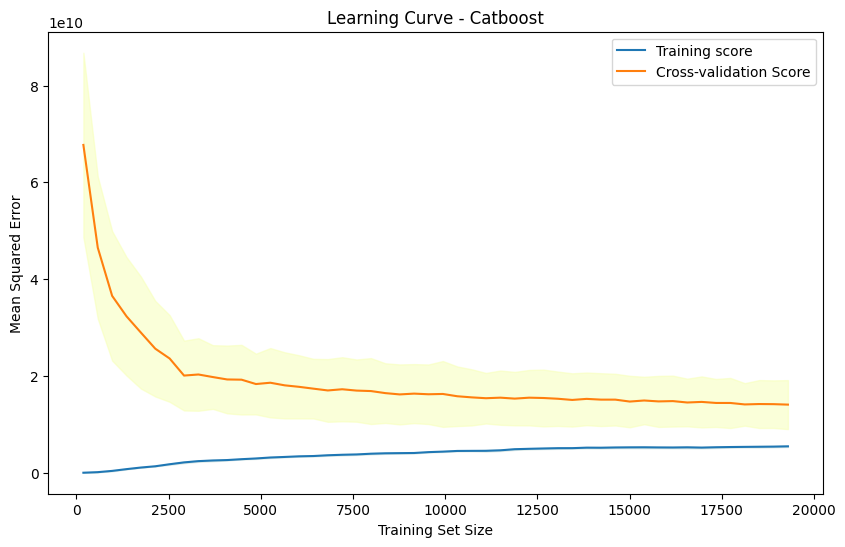

In [ ]:
plot_learning_curve(modelo, X_catboost, y_catboost, model_name="Catboost")

Streaming output truncated to the last 5000 lines.
4:	learn: 267604.5384668	total: 51.2ms	remaining: 2s
5:	learn: 252635.2474501	total: 61.5ms	remaining: 1.99s
6:	learn: 237904.4190269	total: 71.3ms	remaining: 1.96s
7:	learn: 225248.4155171	total: 81.5ms	remaining: 1.96s
8:	learn: 213356.2631341	total: 96.1ms	remaining: 2.04s
9:	learn: 203148.0794600	total: 106ms	remaining: 2.01s
10:	learn: 194337.3392115	total: 116ms	remaining: 1.99s
11:	learn: 186330.5820529	total: 126ms	remaining: 1.97s
12:	learn: 179515.7094315	total: 136ms	remaining: 1.95s
13:	learn: 171965.7025902	total: 146ms	remaining: 1.95s
14:	learn: 166040.0222302	total: 156ms	remaining: 1.93s
15:	learn: 160924.9094214	total: 166ms	remaining: 1.91s
16:	learn: 156798.2802602	total: 176ms	remaining: 1.9s
17:	learn: 152031.8909232	total: 189ms	remaining: 1.92s
18:	learn: 147523.2906808	total: 200ms	remaining: 1.9s
19:	learn: 143390.5655803	total: 217ms	remaining: 1.95s
20:	learn: 140198.8453258	total: 231ms	remaining: 1.97s
21:

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.5min


A saída de streaming foi truncada nas últimas 5000 linhas.
2:	learn: 308036.9512518	total: 73.7ms	remaining: 4.84s
3:	learn: 289584.5932205	total: 105ms	remaining: 5.16s
4:	learn: 271557.0788117	total: 126ms	remaining: 4.92s
5:	learn: 256522.7136363	total: 153ms	remaining: 4.96s
6:	learn: 241385.6546570	total: 176ms	remaining: 4.85s
7:	learn: 228930.2229473	total: 198ms	remaining: 4.74s
8:	learn: 216365.6425309	total: 222ms	remaining: 4.71s
9:	learn: 206062.9100354	total: 244ms	remaining: 4.64s
10:	learn: 197027.3806684	total: 268ms	remaining: 4.61s
11:	learn: 188621.6512829	total: 294ms	remaining: 4.6s
12:	learn: 181456.1810843	total: 325ms	remaining: 4.67s
13:	learn: 173876.0613353	total: 349ms	remaining: 4.63s
14:	learn: 167923.5779503	total: 371ms	remaining: 4.58s
15:	learn: 162585.7060926	total: 394ms	remaining: 4.53s
16:	learn: 158074.1956989	total: 416ms	remaining: 4.47s
17:	learn: 153014.6624856	total: 440ms	remaining: 4.45s
18:	learn: 149295.0350824	total: 466ms	remaining: 4.4

[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  9.7min


A saída de streaming foi truncada nas últimas 5000 linhas.
0:	learn: 346850.3422387	total: 10.1ms	remaining: 2s
1:	learn: 323380.2704483	total: 19.8ms	remaining: 1.96s
2:	learn: 302842.8851501	total: 29.9ms	remaining: 1.96s
3:	learn: 283958.5458385	total: 39.8ms	remaining: 1.95s
4:	learn: 266198.0716939	total: 49.4ms	remaining: 1.93s
5:	learn: 251712.4200578	total: 61.7ms	remaining: 1.99s
6:	learn: 237032.0625338	total: 71.4ms	remaining: 1.97s
7:	learn: 223890.4395593	total: 81.2ms	remaining: 1.95s
8:	learn: 212521.2438825	total: 91.2ms	remaining: 1.94s
9:	learn: 202744.0480287	total: 112ms	remaining: 2.13s
10:	learn: 194051.8249486	total: 127ms	remaining: 2.18s
11:	learn: 185766.0444654	total: 136ms	remaining: 2.14s
12:	learn: 178866.5641322	total: 146ms	remaining: 2.1s
13:	learn: 172304.5036735	total: 156ms	remaining: 2.07s
14:	learn: 165967.1053492	total: 166ms	remaining: 2.04s
15:	learn: 161146.0382999	total: 175ms	remaining: 2.01s
16:	learn: 156512.2936744	total: 184ms	remaining: 

[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed: 20.9min


A saída de streaming foi truncada nas últimas 5000 linhas.
0:	learn: 349040.4279789	total: 11.6ms	remaining: 2.31s
1:	learn: 325032.8703466	total: 24.6ms	remaining: 2.44s
2:	learn: 304014.7654485	total: 34.6ms	remaining: 2.27s
3:	learn: 285441.7570122	total: 44.5ms	remaining: 2.18s
4:	learn: 267957.7702778	total: 54.4ms	remaining: 2.12s
5:	learn: 253284.8084534	total: 73ms	remaining: 2.36s
6:	learn: 238721.2830218	total: 95.1ms	remaining: 2.62s
7:	learn: 226537.1024612	total: 105ms	remaining: 2.52s
8:	learn: 215329.3686189	total: 115ms	remaining: 2.44s
9:	learn: 204684.4880134	total: 128ms	remaining: 2.44s
10:	learn: 195927.6216005	total: 149ms	remaining: 2.57s
11:	learn: 188032.6179952	total: 161ms	remaining: 2.52s
12:	learn: 180946.4989944	total: 170ms	remaining: 2.45s
13:	learn: 173671.4057940	total: 181ms	remaining: 2.4s
14:	learn: 167655.3048124	total: 190ms	remaining: 2.35s
15:	learn: 162853.0075311	total: 200ms	remaining: 2.3s
16:	learn: 158036.8601985	total: 210ms	remaining: 2.

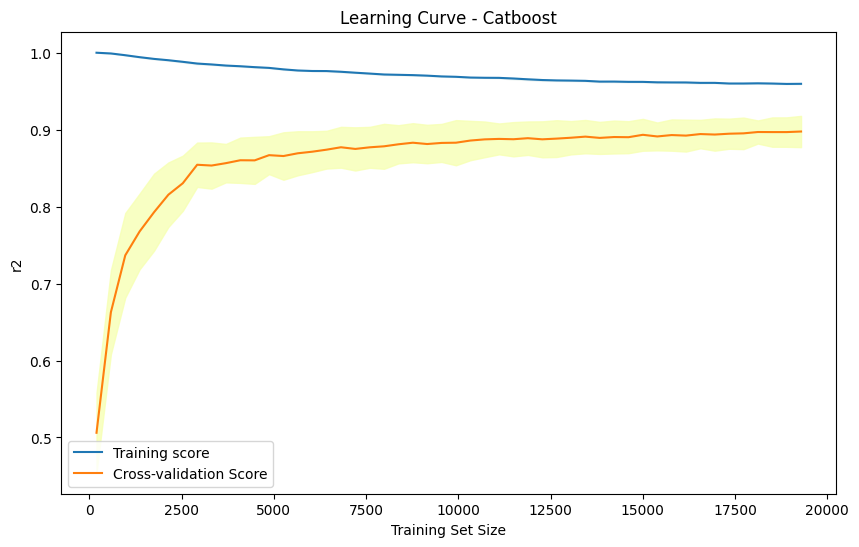

In [ ]:
plot_learning_curve_r2(modelo, X_catboost, y_catboost, model_name="Catboost")